# Albero ricoprente di costo minimo capacitato

## Abstract
Presento un algoritmo genetico con una codifica specializzata, inizializzazione aleatoria per ottimizzare topologie delle reti di telecomunicazione.Questo problema NP-hard è spesso così
vincolato che un'inizializzazione aleatoria e algoritmi genetici standard generano spesso soluzioni inammissibili. Questa strategia di ottimizzazione può essere usata anche per altri problemi simili.

## Introduzione
Il problema CMST è un'estensione del MST (minimum spanning tree). Un problema che mi chiede di trovare quale struttura
garantisca la connessione fra tutti i nodi con il costo minore. Qui considero un solo flusso d'informazioni (o merci),
cioè single commodity. In generale queste informazioni scorrono su link di capacità finita da un nodo radice a dei nodi
foglia che agiscono da "sink" delle informazioni, i consumatori.
Il problema più spesso risolto nella pratica è quello del MST; dal quale deriviamo il protocollo di rete STP (spanning tree
protocol) di livello link-local (ISO/OSI layer 2). Questa invece è una versione constrained (capacitata) MST.
La formulazione proposta in questo progetto va in una direzione diversa,
sappiamo che nel caso in cui ci sia un server centrale che spinge informazioni lungo la rete il limite di capacità dei link è ricavabile con un probelma di flusso massimo (risolvibile con ad esempio l'algoritmo di Ford&Fulkerson).
* Che dire del caso in cui io abbia decine di nodi collegati al server centrale tramite una dorsale, come valuto la resilienza di una tale rete?
* Come posso garantire che il minor numero di utenti si scolleghi dalla rete nel caso in cui la dorsale si interrompa?
* Per quale tipo di metrica è meglio ottimizzare, la posa in opera dell'infrastruttura o la latenza sulla linea?
* Che dire della ridondanza della rete?

Queste sono solo alcune delle domande che posso includere nel modello come "criteri" guida decisionali. Nel caso in
esame prendo solo in considerazione le prime due domande della lista.

    Vorrei limitare il numero di nodi che sono collegati alla radice attraverso un singolo collegamento (dorsale).

Un primo modo per risolvere è avere un albero "bilanciato", cioè con un numero di nodi circa uguale in ogni ramo della radice. Questo garantisce che, per esempio, se su $ N $ collegamenti uscenti dalla radice se ne interrompesse uno, avrei $ \frac{1}{N} $ utenti scollegati rispetto al totale. Lo stesso ragionamento lo posso ripetere ricorsivamente per ogni sottoalbero che si diparte dalla sorgente. Ciò che vorrei è limitare il numero massimo di utenti serviti da un certo collegamento, in modo da limitare il numero di utenti scollegati in caso di guasti su quello specifico collegamento.

## Formulazione del problema
Una rete di telecomunicazioni può essere modellata da un grafo $ G = (N, A) $ con $ N $ insieme dei nodi che qui rappresenta un cliente che si connette alla rete (telecomunicazioni, gas, in generale è una rete di flusso). L'
insieme $ A $ è l'insieme degli archi che sono attivi e che collegano i nodi nel grafo, in questo caso rappresentano linee attive ed utilizzabili. La rete si ipotizza usi collegamenti bidirezionali e quindi uso un grafo non
orientato. Inoltre ipotizzo che non ci siano archi paralleli (ridondanti), questi in realtà si aggiungono per aumentare il data rate o l'affidabilità. Qui non vengono esaminati, anche se per questo algoritmo non cambia molto.

Impostiamo il seguente programma:

$$ Min \sum_{(i,j) \in A}\ c_{ij} x_{ij} \ $$
$$ \sum_{(j,i) \in A}\ x_{ij} -  \sum_{(i,j) \in A}\ x_{ij} = b_j	 \quad \forall i \in N \qquad (1) \ $$
$$ \sum_{(i,j) \in A}\ y_{ij}  	\leq 1 \quad \forall j \in N 	\setminus{i} \qquad (2) \ $$
$$ \sum_{(i,j) \in S}\ x_{ij}  	\leq |S| - 1 \quad \forall S \in N  \qquad (3) \ $$
$$ x_{ij} \leq  Qy_{ij}  	 \quad \forall (i,j)  \in A \qquad (4)	\ $$
$$ y_{ij} \in \{ 0,1 \}  	 \quad \forall (i,j)  \in A \qquad (5)	\ $$
$$ x_{ij} \geq 0 	 \quad \forall (i,j)  \in A 	\qquad (6) \ $$

$ y_{ij} $ sono le variabili decisionali (creo un collegamento fra $ i $ e $ j $)

$ x_{ij} $ sono le variabili di flusso

Questa variante single commodity del problema MST capacitato può essere modificata per accomodare altri tipi di flusso
i quali non devono mescolarsi o che devono essere in generale sempre distinguibili (eg. traffico di controllo e traffico
utenti) ottenendo la variante multicommodity.

#### Descrizione dei vincoli
* Il vincolo $ (1) $ è il vincolo di conservazione del flusso, che garantisce che ogni utente venga soddisfatto con la sua
richiesta di pacchetti e che i pacchetti non vengano creati o distrutti dal nulla.
* Il vincolo $ (2) $ è il vincolo che mi permette di selezionare un solo arco entrante nel generico nodo $ i-esimo $
* Il vincolo $ (4) $ è il vincolo di linking. Questo è il vincolo complicante, infatti se $ y_{ij} = 0 $ allora non scorre niente; invece se $ y_{ij} = 1 $ il flusso potrebbe non avere più limiti perché posso porre $ Q \to \infty $ (o comunque un big-M). Nel mio caso invece pongo $ Q = n $ con $ n $ un numero opportuno, un upper bound sul numero di nodi serviti da un certo arco. Questo upper bound sarà tanto più stringente quanto più il ramo è vicino alla radice (più sono in alto e più traffico trasporto).
* Il vincolo $ (3) $ è il vincolo di subtour elimination, ogni sottoinsieme di $ k $ nodi deve avere al massimo $ k-1 $ archi. Questo potrebbe essere sostituito da i vincoli di Miller-Tucker-Zemlin che sono in numero polinomiale.

### Complessità
Questo problema a causa dei vincoli di linking è in complessità esponenziale. Questi vincoli legano le variabili
decisionali con quelle di flusso.
Come primo tentativo potrei fare un rilassamento continuo della variabile binaria $ y_{ij} $. Questo però, porterebbe a snaturare il vincolo logico ottenendo $ y_{ij} \geq  \frac{x_{ij}}{Q}$ che per $ Q \to \infty $
che diverrebbe  $ y_{ij} \geq 0 $ e cioè un vincolo inutile.
Oppure posso tentare di rafforzare la formulazione prendendo un $ Q $p leggermente sopra la capacità massima (dunque non un big-M) e sottraendo la richiesta $ b_j $. Attenzione, è possibile costruire un piccolo esempio che dimostra come questo porta a sottostimare i costi della rete.
Costruirsi un rilassamento adeguato non è banale, dunque la prima soluzione euristica che ha dato dei risultati "accettabili" è quella dell'algoritmo genetico di seguito descritto.

### Ipotesi operative
Ora proseguo con le ipotesi operative:
1. La locazione di ogni nodo è già fornita
2. I nodi sono perfettamente affidabili
3. Ogni collegamento è bidirezionale
4. Non ci sono collegamenti ridondanti
5. I collegamenti sono attivi o rotti
6. I fallimenti sono indipendenti fra loro
7. Non vengono esaminate riparazioni
8. La capacità $ Q $ è fissata ad un valore intero

## Algoritmo genetico

Inizializzo con tutti gli import e i parametri interattivi.

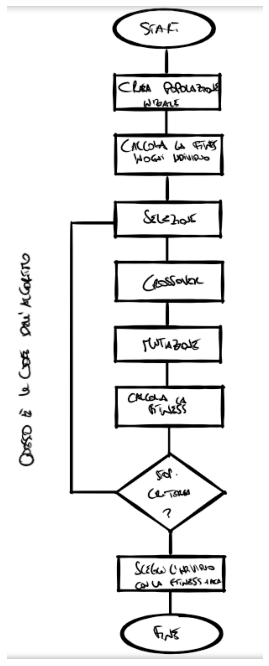

In [18]:
import sys
from random import seed, randint
from time import process_time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from CMST_package.population_generator import draw_graph, generate_population, NUMB_GENER, TREE_LIKE_LAYOUT, breeding_mutation, self_mutation, prim, measure_branch

# MODIFICAMI!!!
NUM_NODES = 8
MESH_LIKE_LAYOUT = 0
HOF_SIZE = 3
MAXIMUM_FITNESS = 1000
POP_SIZE = 100
SELF_MUTATE_PROB = 0.3
CROSS_MUTATE_PROB = 0.7
ROOT = 1
CAPACITY = 4

img = mpimg.imread('../artifacts/flowchart.PNG')
plt.figure(figsize=(12, 12))
plt.axis("off")

imgplot = plt.imshow(img)

## Matrice di adiacenza aleatoria
Per testare l'algoritmo ho bisogno di avere dei grafi di prova. Questi li posso produrre a partire da dati reali (ad esempio posizioni GPS) oppure posso generarli
sinteticamente. Ho scelto la seconda strada perché più veloce, non devo stare a trovare dati significati e prepararli.

In [19]:
ADJACENCY_MATRIX = [[0 for x in range(NUM_NODES)] for x in range(NUM_NODES)]


def random_adjacency_matrix(matrix):
    """
    Funzione che crea una matrice di adiacenza aleatoria per la simulazione dell'algoritmo. Questa sezione è necessaria
    per testare come si comporta l'algoritmo al variare del grafo, dei pesi o degli archi cioè di chi collego o no.

    QUI IL SEED È PREFISSATO, NON È REALMENTE ALEATORIO, SE LO SI VUOLE ALEATORIO, TOGLIERE IL SEED
    #TODO: la firma è simil-C e fa schifo, restituisci la matrice

    :param matrix: matrice in cui appoggiare i risultati
    :return: matrice del grafo su cui si lavora (da implementare il return)
    """
    global MAXIMUM_FITNESS
    for col in range(len(ADJACENCY_MATRIX) - 1):
        for row in range(col, len(ADJACENCY_MATRIX[col]) - 1):
            if col != row:
                value = randint(0, 100)
            else:
                value = sys.maxsize
            ADJACENCY_MATRIX[col][row] = value
            ADJACENCY_MATRIX[row][col] = value

            if row != col:
                if value > MAXIMUM_FITNESS:
                    MAXIMUM_FITNESS = value
                print('{:3}'.format(ADJACENCY_MATRIX[col][row]), end=" ")
                matrix[col][row] = ADJACENCY_MATRIX[col][row]
        print()

## Codifica

Definisco come soluzione del mio problema una qualunque struttura connessa aciclica che garantisca la copertura di tutti i nodi della rete. Una tale soluzione è un albero ricoprente, quello a cui sono interessato è l'albero
ricoprente di costo minimo soggetto al vincolo di capacità che dovrà essere rispettato per ogni singolo arco.
Poiché con questo algoritmo genetico in uscita avrò un cromosoma (o una rappresentazione equivalente) la soluzione dunque è il cromosoma vincente di fra tutta la popolazione. A questo proposito devo rappresentare:
1. Cosa è un cromosoma
2. Come è fatto un cromosoma

[Savic e Walter](https://doi.org/10.1080/03052150512331303436) hanno usato stringhe di interi a lunghezza variabile per rappresentare una rete di distribuzione idrica.

Consultare il seguente notebook riguardante l'[individuo](individual.ipynb) soluzione e la sua codifica.

## Descrizione dell'algoritmo

Per rendere la ricerca efficiente la popolazione iniziale consiste di reti a mesh rappresentate dall'individuo con genoma composto da $ \frac{n*(n-1)}{2}  $ interi.
In sostanza tratto una popolazione come una lista di individui. Per una descrizione delle funzioni usate per l'evoluzione della popolazione
e la fitness dell'individuo consultare il file riguadante la [popolazione](population_generator.ipynb).

> 1. Setup dell'algoritmo

        * Settaggio dei parametri
        * Matrice `ADJACENCY_MATRIX` come matrice iniziale in cui effetturae gli step intermedi (per non sporcare quella buona finale)

> 2. Inizializzazione dell'algoritmo, creo la matrice di adiacenza aleatoria e la visualizzo

 73   4  54  61  73   1 
 26  59  62  35  83 
 20   4  66  62 
 41   9  31 
 95  46 
  5 



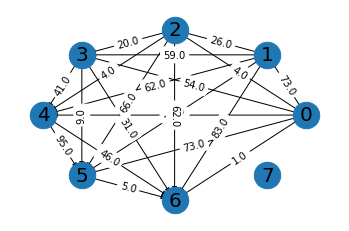

<Figure size 864x864 with 0 Axes>

In [20]:
from CMST_package.hall_of_fame import Hof

seed(10)
Mat = np.zeros((NUM_NODES, NUM_NODES))
random_adjacency_matrix(Mat)
g = nx.from_numpy_matrix(Mat, create_using=nx.DiGraph)
draw_graph(g, MESH_LIKE_LAYOUT)

> 2. Inizializzo la Hall of Fame per memorizzare le migliori soluzioni

In [21]:
hall_of_fame = Hof(HOF_SIZE)

> 3. Genero una popolazione con la quale lanciare l'algoritmo

In [22]:
genome = generate_population(POP_SIZE + (POP_SIZE % 2), int(NUM_NODES * (NUM_NODES + 1) / 2))

> 4. Valutazione della fitness di ogni individuo della popolazione e modifica dei parametri degli individui (riporto il codice per comodità)

In [23]:
def fitness_evaluation(individuals):
    for ind in individuals:
        matrix = ind.reshape2matrix(NUM_NODES)

        # Apply Prim's Algorithm to get Tree
        tree = prim(matrix)

        # Depth first search starting from ROOT
        over_capacity = False
        for edge in tree:
            temp_weight = 0
            if edge[0] == ROOT:
                temp_weight = measure_branch(tree, edge[1], ROOT)
            elif edge[1] == ROOT:
                temp_weight = measure_branch(tree, edge[0], ROOT)
            if temp_weight > CAPACITY:
                ind.tree = tree
                ind.fitness = MAXIMUM_FITNESS
                over_capacity = True

        # Get weight of converted representation if under capacity
        if not over_capacity:
            weight = 0
            for edge in tree:
                (col, row) = edge
                weight += ADJACENCY_MATRIX[col - 1][row - 1]
            ind.tree = tree
            ind.fitness = weight


fitness_evaluation(genome)

> 5. Inizio a popolare la Hall of Fame e visualizzare le migliori soluzioni intermedie

In [24]:
hall_of_fame.update(genome)
print(hall_of_fame)

Fitness: 154
Tree: [(1, 8), (8, 3), (1, 4), (3, 2), (1, 6), (1, 7), (8, 5), (0, 0), (0, 0)]

Fitness: 164
Tree: [(1, 7), (1, 5), (7, 6), (1, 3), (1, 8), (1, 2), (3, 4), (0, 0), (0, 0)]

Fitness: 235
Tree: [(1, 6), (6, 7), (1, 5), (5, 4), (4, 3), (6, 2), (1, 8), (0, 0), (0, 0)]




> 6. Loop evolutivo
        * Mutazione crossover
        * Mutazione singola dalla popolazione in uscita dal crossover
        * Valutazione della fitness
        * Update della Hall of Fame

In [25]:
start = process_time()

for cur_gen in range(NUMB_GENER):
    new_chromosome = breeding_mutation(genome, CROSS_MUTATE_PROB)
    genome = self_mutation(new_chromosome, SELF_MUTATE_PROB)
    fitness_evaluation(genome)
    hall_of_fame.update(genome)

stop = process_time()

> 7. Visualizzazione dei risultati

In [26]:
print(hall_of_fame)
print("Time: ", stop - start)
print("ROOT: ", ROOT)
print("CAPACITY: ", CAPACITY)


Fitness: 83
Tree: [(1, 4), (4, 6), (1, 8), (8, 5), (4, 3), (8, 7), (8, 2), (0, 0), (0, 0)]

Fitness: 190
Tree: [(1, 7), (1, 2), (7, 4), (1, 3), (2, 6), (3, 8), (7, 5), (0, 0), (0, 0)]

Fitness: 199
Tree: [(1, 8), (8, 2), (1, 6), (2, 3), (1, 4), (4, 5), (6, 7), (0, 0), (0, 0)]


Time:  2.515625
ROOT:  1
CAPACITY:  4


> 8. Plot delle migliori soluzioni

[(1, 8), (8, 3), (1, 4), (3, 2), (1, 6), (1, 7), (8, 5)]


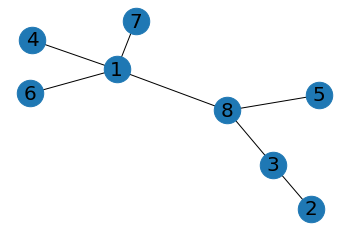

<Figure size 864x864 with 0 Axes>

[(1, 7), (1, 5), (7, 6), (1, 3), (1, 8), (1, 2), (3, 4)]


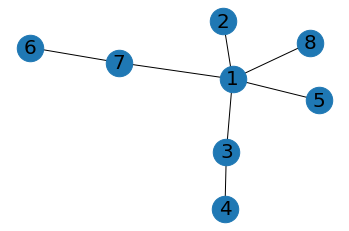

<Figure size 864x864 with 0 Axes>

[(1, 6), (6, 7), (1, 5), (5, 4), (4, 3), (6, 2), (1, 8)]


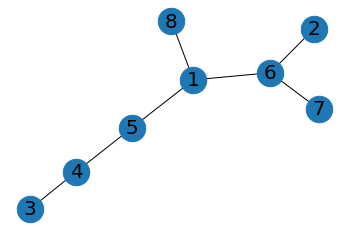

<Figure size 864x864 with 0 Axes>

[(1, 4), (4, 6), (1, 8), (8, 5), (4, 3), (8, 7), (8, 2)]


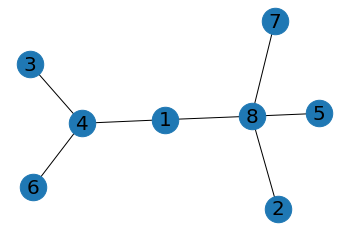

<Figure size 864x864 with 0 Axes>

[(1, 7), (1, 2), (7, 4), (1, 3), (2, 6), (3, 8), (7, 5)]


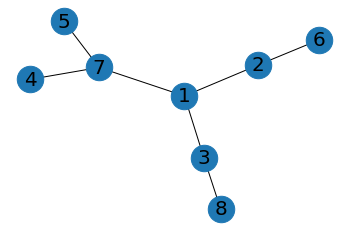

<Figure size 864x864 with 0 Axes>

[(1, 8), (8, 2), (1, 6), (2, 3), (1, 4), (4, 5), (6, 7)]


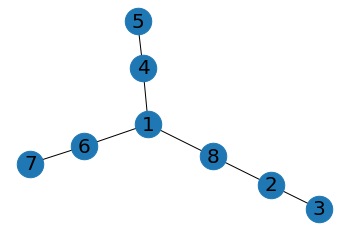

<Figure size 864x864 with 0 Axes>

In [27]:
for candidate in hall_of_fame.paths:
    candidate = [item for item in candidate if item != (0, 0)]
    print(candidate)
    G = nx.Graph()
    G.add_edges_from(candidate)
    draw_graph(G, TREE_LIKE_LAYOUT)